In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from dataset import SKmake, QM7, QM7b, QM7X, QM9, ANI1x
from learning import Learn, Selector

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

<class 'cosmosis.dataset.SKmake'> dataset created...
epoch: 0 of 10, train loss: 12872.903822157117, val loss: 1546.7387451171876, lr: 0.01
epoch: 1 of 10, train loss: 1227.244952166522, val loss: 1316.5195434570312, lr: 0.01
epoch: 2 of 10, train loss: 1059.0432626229745, val loss: 968.8276123046875, lr: 0.01
epoch: 3 of 10, train loss: 1031.8394119827835, val loss: 922.4639526367188, lr: 0.01
epoch: 4 of 10, train loss: 1006.7870415581597, val loss: 959.551513671875, lr: 0.01
epoch: 5 of 10, train loss: 970.1020846896702, val loss: 1164.6700439453125, lr: 0.01
epoch: 6 of 10, train loss: 939.2855360243055, val loss: 935.4112670898437, lr: 0.005
epoch: 7 of 10, train loss: 867.3360505280672, val loss: 785.3703125, lr: 0.005
epoch: 8 of 10, train loss: 828.4569012677229, val loss: 828.0775268554687, lr: 0.005
epoch: 9 of 10, train loss: 749.7772035951967, val loss: 770.9599975585937, lr: 0.005
test loss: 699.194091796875
y_pred:
tensor([[-193.4143],
        [ 261.5168],
        [-180.1

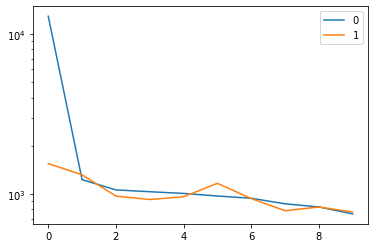

learning time: 0:00:07.739434


In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 2}

l = Learn(SKmake, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

<class 'dataset.QM7'> dataset created...
epoch: 0 of 100, train loss: 1519.2987232576243, val loss: 1432.6759972907603, lr: 0.01
epoch: 10 of 100, train loss: 119.06004658672545, val loss: 91.00710618495941, lr: 0.01
epoch: 20 of 100, train loss: 88.40438212951024, val loss: 97.57528948783875, lr: 0.01
epoch: 30 of 100, train loss: 79.6245805753602, val loss: 89.84297144412994, lr: 0.005
epoch: 40 of 100, train loss: 80.55107282267676, val loss: 68.96436554193497, lr: 0.005
epoch: 50 of 100, train loss: 62.75649092594782, val loss: 60.48257511854172, lr: 0.0025
epoch: 60 of 100, train loss: 61.82300834523307, val loss: 63.92678099870682, lr: 0.00125
epoch: 70 of 100, train loss: 58.588639782534706, val loss: 67.9016165137291, lr: 0.00125
epoch: 80 of 100, train loss: 60.11174202627606, val loss: 57.528071224689484, lr: 0.000625
epoch: 90 of 100, train loss: 58.34168013599184, val loss: 57.18498086929321, lr: 0.000625
test loss: 59.05541092157364
y_pred:
tensor([[-1257.5328],
        [-

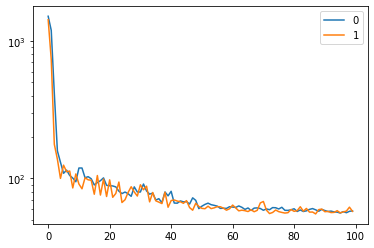

learning time: 0:00:53.496276


In [3]:
model_params = {'D_in': 23*23+23*3+23*16, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'features': ['coulomb','xyz'],
             'targets': ['ae'],
             'embed': [('atoms',7,16,0,True)],
             'in_file': './data/qm7/qm7.mat'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn(QM7, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=100)

<class 'dataset.QM7b'> dataset created...
epoch: 0 of 100, train loss: 1538.4583614241794, val loss: 1425.0595097579062, lr: 0.01
epoch: 10 of 100, train loss: 128.73421757088767, val loss: 165.15493661165237, lr: 0.01
epoch: 20 of 100, train loss: 109.37808675236172, val loss: 100.75802880525589, lr: 0.01
epoch: 30 of 100, train loss: 83.35279774665833, val loss: 82.74864763021469, lr: 0.005
epoch: 40 of 100, train loss: 79.439281920592, val loss: 75.65017622709274, lr: 0.005
epoch: 50 of 100, train loss: 79.78117651409573, val loss: 77.85192787647247, lr: 0.0025
epoch: 60 of 100, train loss: 70.97416806883282, val loss: 72.40451389551163, lr: 0.00125
epoch: 70 of 100, train loss: 67.02791654401355, val loss: 73.56826907396317, lr: 0.000625
epoch: 80 of 100, train loss: 67.06300903691186, val loss: 73.57977384328842, lr: 0.000625
epoch: 90 of 100, train loss: 64.1529414123959, val loss: 72.51706105470657, lr: 0.0003125
test loss: 71.04853409528732
y_pred:
tensor([[-1820.7994],
       

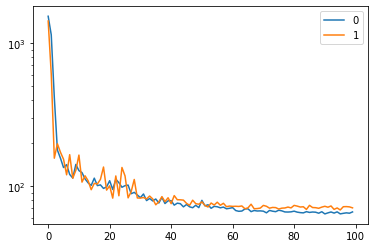

learning time: 0:00:49.005304


In [4]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'features': ['coulomb'],
            'targets': ['E'],
            'in_file': './data/qm7b/qm7b.mat'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn(QM7b, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=512, epochs=100)

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
<class 'dataset.QM7X'> dataset created...
epoch: 0 of 100, train loss: 35.330960638614876, val loss: 12.74306784484911, lr: 0.01
epoch: 10 of 100, train loss: 2.762725710720113, val loss: 2.2979526280143263, lr: 0.01
epoch: 20 of 100, train loss: 2.002833332753734, val loss: 1.744701342274189, lr: 0.01
epoch: 30 of 100, train loss: 1.941787621854481, val loss: 2.2992298409392835, lr: 0.01
epoch: 40 of 100, train loss: 1.6679775260533785, val loss: 1.6596494944372178, lr: 0.005
epoch: 50 of 100, train loss: 1.7250261699718177, val loss: 1.70446

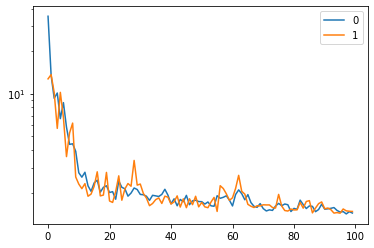

learning time: 0:02:08.854113


In [5]:
model_params = {'D_in': 23*3+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'features': ['atXYZ'],
             'pad': 23,
             'targets': ['eAT'],
             'embed': [('atNUM',9,64,0,True)],
             'selector': ['opt'],
             'use_h5': False}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn(QM7X, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=100)

#find the longest molecule
#qm7x = QM7X(**ds_params)
#l = 0
#for i in qm7x.ds_idx:
#    s = qm7x[i][0].shape.numel()
#    if s > l:
#        l = s
#print(l)

loading QM9 datadic from a pickled copy...
<class 'dataset.QM9'> dataset created...
epoch: 0 of 50, train loss: 220.60759661272036, val loss: 85.87576408799745, lr: 0.01
epoch: 5 of 50, train loss: 33.29114986095238, val loss: 29.457712480569842, lr: 0.01
epoch: 10 of 50, train loss: 25.36837961633664, val loss: 24.599824545473098, lr: 0.01
epoch: 15 of 50, train loss: 19.525199435827705, val loss: 22.00610387831116, lr: 0.01
epoch: 20 of 50, train loss: 23.394530225991254, val loss: 31.397898389965057, lr: 0.01
epoch: 25 of 50, train loss: 17.22168465329052, val loss: 19.1437839478302, lr: 0.01
epoch: 30 of 50, train loss: 16.77285921680696, val loss: 16.371643164470672, lr: 0.01
epoch: 35 of 50, train loss: 15.996944815961566, val loss: 13.368740440260888, lr: 0.01
epoch: 40 of 50, train loss: 14.361012144048056, val loss: 12.990280638814927, lr: 0.005
epoch: 45 of 50, train loss: 14.998716593714397, val loss: 13.821054602108958, lr: 0.005
test loss: 10.230546944244384
y_pred:
tensor

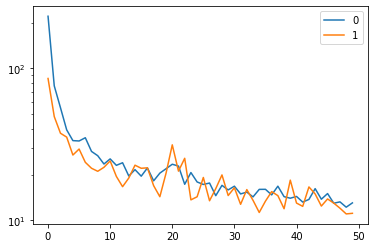

learning time: 0:00:42.887192


In [8]:
model_params = {'D_in': 12*12+12*12+12+12*12*16, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'n': 133885, 
             'features': ['distance','coulomb','mulliken'],
             'embed': [('adjacency',4,16,0,True)], 
             'targets': ['U0'],
             'pad': 12, 
             'filter_on': ('n_atoms','<','13'),
             'use_pickle': 'n_atoms_less_than_13.p'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn(QM9, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=50)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  1
QM9 molecules scanned:  10001
QM9 molecules created:  10001
QM9 molecules scanned:  20001
QM9 molecules created:  20001
QM9 molecules scanned:  30001
QM9 molecules created:  30001
QM9 molecules scanned:  40001
QM9 molecules created:  40001
QM9 molecules scanned:  50001
QM9 molecules created:  50001
QM9 molecules scanned:  60001
QM9 molecules created:  60001
QM9 molecules scanned:  70001
QM9 molecules created:  70001
QM9 molecules scanned:  80001
QM9 molecules created:  80001
QM9 molecules scanned:  90001
QM9 molecules created:  90001
QM9 molecules scanned:  100001
QM9 molecules created:  100001
QM9 molecules scanned:  110001
QM9 molecules created:  110001
QM9 molecules scanned:  120001
QM9 molecules created:  120001
QM9 molecules scanned:  130001
QM9 molecules created:  130001
total QM9 molecules created: 130831
pickling a copy of the QM9 datadic...
<class 'dataset.QM9'> dataset created...
epoch: 0 of 20, train

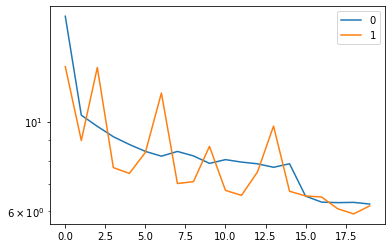

learning time: 0:55:46.308768


In [9]:
model_params = {'D_in': 29*29+29*29+29*29*8, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'n': 133885, 
             'features': ['distance','coulomb'],
             'embed': [('adjacency',4,8,0,True)],
             'targets': ['U0'],
             'pad': 29, 
             'filter_on': False,
             'use_pickle': 'qm9.p'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn(QM9, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=32, epochs=20)

structures loaded:  9341
<class 'dataset.ANI1x'> dataset created...
epoch: 0 of 100, train loss: 328.4656571288908, val loss: 172.7988581851566, lr: 0.01
epoch: 10 of 100, train loss: 55.81039041620054, val loss: 50.74831659053924, lr: 0.005
epoch: 20 of 100, train loss: 35.44786570707061, val loss: 39.623014971425995, lr: 0.005
epoch: 30 of 100, train loss: 33.012975617856746, val loss: 40.064536077990844, lr: 0.0025
epoch: 40 of 100, train loss: 27.113757026502213, val loss: 29.264937394258386, lr: 0.00125
epoch: 50 of 100, train loss: 26.960563925300875, val loss: 32.87949641792702, lr: 0.00125
epoch: 60 of 100, train loss: 26.572695998868912, val loss: 25.64557315577964, lr: 0.000625
epoch: 70 of 100, train loss: 27.324498797435755, val loss: 26.932975834937462, lr: 0.0003125
epoch: 80 of 100, train loss: 23.713686249738164, val loss: 27.838486185697775, lr: 0.00015625
epoch: 90 of 100, train loss: 24.45372185553834, val loss: 24.045732918525033, lr: 7.8125e-05
test loss: 22.095745

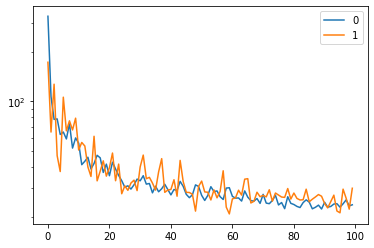

learning time: 0:02:44.907612


In [2]:
model_params = {'D_in': 64*63+63+63+63, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'padding_idx': 0}

ds_params = {'features': ['coordinates'],
             'targets': ['wb97x_dz.energy'],
             'embed': [('atomic_numbers',6,64,0,True)],
             'pad': 63, #length of the longest molecule in the dataset
             'criterion': None,
             'conformation': 'random',
             'in_file': './data/ani1x/ani1x-release.h5'}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.15,.7)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn(ANI1x, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=100)

In [ ]:
.